Copyright 2022 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
!pip install gspread
!pip install fastdtw

In [ ]:
from google.colab import auth
from oauth2client.client import GoogleCredentials
import gspread
import pandas as pd
import fastdtw
from scipy.spatial.distance import euclidean
import random

import numpy as np
import matplotlib.pyplot as plt

auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
ss_name = "Sample_data_for_DTW" #@param {type: "string"}
sheet_name = "sample_data" #@param {type: "string"}
workbook = gc.open(ss_name)
worksheet = workbook.worksheet(sheet_name)
df_sheet = pd.DataFrame(worksheet.get_all_values())

df_sheet.columns = list(df_sheet.loc[0, :])
df_sheet.drop(0, inplace=True)
df_sheet.reset_index(inplace=True)
df_sheet.drop('index', axis=1, inplace=True)
df_sheet.head()

,date,geo,KPI
0,2021-08-01,Tokyo,1108
1,2021-08-02,Tokyo,873
2,2021-08-03,Tokyo,892
3,2021-08-04,Tokyo,961
4,2021-08-05,Tokyo,931


In [ ]:
# @markdown Date
date_col = 'date'  #@param {type: "string"}
# @markdown Pre Test End Date
pre_test_end = '2021-10-31'  #@param {type: "date"}
# @markdown KPI col
kpi_col = 'KPI'  #@param {type: "string"}
# @markdown Group col
group_col = 'geo'  #@param {type: "string"}

df_sheet[date_col] = pd.to_datetime(df_sheet[date_col])

temp = df_sheet[[date_col, kpi_col,
                group_col]].groupby([date_col, group_col]).sum().reset_index()
temp_pvt = pd.pivot_table(temp, index=date_col, columns=group_col)
temp_pvt.columns = temp_pvt.columns.droplevel(0)

date_list = pd.date_range(
    start=min(df_sheet[date_col]),
    end=max(df_sheet[date_col]),
    freq='D',
    name=date_col)
df_design_all = pd.merge(
    pd.DataFrame(date_list), temp_pvt, on=date_col, how='left')
df_design_all.fillna(0, inplace=True)
min_date = pd.to_datetime(min(df_sheet[date_col]))
pre_test_days = (pd.to_datetime(pre_test_end) - min_date).days + 1
df_design_pre = df_design_all[0:pre_test_days]
df_design_pre

,date,Aichi,Akita,Aomori,Chiba,Ehime,Fukui,Fukuoka,Fukushima,Gifu,Gunma,Hiroshima,Hokkaido,Hyogo,Ibaraki,Ishikawa,Iwate,Kagawa,Kagoshima,Kanagawa,Kumamoto,Kyoto,Mie,Miyagi,Miyazaki,Nagano,Nagasaki,Nara,Niigata,Oita,Okayama,Okinawa,Osaka,Saitama,Shiga,Shizuoka,Tochigi,Tokushima,Tokyo,Toyama,Wakayama,Yamagata,Yamaguchi,Yamanashi
0,2021-08-01,346.0,17.0,29.0,267.0,34.0,12.0,171.0,50.0,69.0,55.0,71.0,144.0,178.0,134.0,30.0,42.0,20.0,53.0,421.0,72.0,75.0,61.0,93.0,49.0,51.0,27.0,32.0,84.0,30.0,57.0,34.0,382.0,308.0,54.0,136.0,62.0,18.0,1108.0,29.0,26.0,30.0,26.0,57.0
1,2021-08-02,262.0,19.0,34.0,197.0,24.0,24.0,143.0,40.0,48.0,46.0,55.0,165.0,178.0,108.0,38.0,27.0,22.0,40.0,350.0,69.0,83.0,56.0,96.0,24.0,41.0,25.0,25.0,72.0,16.0,51.0,31.0,316.0,269.0,39.0,85.0,59.0,43.0,873.0,29.0,19.0,42.0,21.0,20.0
2,2021-08-03,210.0,21.0,29.0,221.0,31.0,10.0,105.0,49.0,42.0,49.0,66.0,105.0,179.0,105.0,22.0,41.0,27.0,74.0,275.0,27.0,69.0,68.0,92.0,25.0,48.0,40.0,26.0,59.0,20.0,51.0,21.0,353.0,237.0,48.0,95.0,53.0,12.0,892.0,19.0,15.0,28.0,23.0,24.0
3,2021-08-04,277.0,20.0,38.0,177.0,20.0,11.0,139.0,49.0,50.0,39.0,62.0,121.0,167.0,168.0,32.0,25.0,20.0,28.0,344.0,44.0,72.0,38.0,61.0,29.0,56.0,28.0,39.0,59.0,20.0,45.0,30.0,327.0,297.0,31.0,113.0,77.0,7.0,961.0,36.0,22.0,47.0,23.0,36.0
4,2021-08-05,230.0,22.0,30.0,210.0,20.0,21.0,146.0,54.0,52.0,35.0,59.0,111.0,189.0,145.0,25.0,29.0,30.0,31.0,280.0,36.0,54.0,41.0,52.0,13.0,45.0,27.0,28.0,71.0,28.0,55.0,16.0,323.0,240.0,35.0,90.0,54.0,10.0,931.0,28.0,15.0,23.0,33.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2021-10-27,260.0,17.0,29.0,184.0,22.0,11.0,171.0,55.0,39.0,32.0,55.0,178.0,147.0,80.0,26.0,29.0,27.0,35.0,339.0,36.0,78.0,35.0,57.0,28.0,63.0,34.0,30.0,73.0,24.0,56.0,15.0,347.0,214.0,32.0,60.0,38.0,15.0,918.0,23.0,23.0,23.0,32.0,33.0
88,2021-10-28,226.0,36.0,21.0,186.0,23.0,19.0,170.0,51.0,43.0,60.0,71.0,152.0,166.0,96.0,21.0,40.0,12.0,45.0,293.0,53.0,77.0,86.0,67.0,38.0,50.0,19.0,23.0,45.0,32.0,42.0,36.0,355.0,242.0,31.0,117.0,46.0,21.0,912.0,26.0,25.0,13.0,28.0,20.0
89,2021-10-29,238.0,19.0,27.0,270.0,38.0,15.0,159.0,56.0,63.0,56.0,57.0,160.0,144.0,117.0,20.0,30.0,40.0,26.0,391.0,48.0,67.0,49.0,74.0,20.0,69.0,24.0,42.0,63.0,30.0,51.0,31.0,379.0,288.0,48.0,157.0,62.0,8.0,913.0,29.0,27.0,22.0,35.0,29.0
90,2021-10-30,312.0,17.0,43.0,255.0,40.0,33.0,169.0,55.0,78.0,71.0,86.0,204.0,189.0,192.0,56.0,17.0,13.0,58.0,510.0,50.0,101.0,64.0,84.0,17.0,76.0,29.0,61.0,81.0,29.0,56.0,30.0,490.0,386.0,55.0,140.0,80.0,16.0,1019.0,33.0,21.0,31.0,54.0,36.0


In [ ]:
# @markdown Optional : drop col?
has_drop_cols = 'No'  #@param ["Yes", "No"]

# @markdown drop col list
drop_cols = ['Tokyo']  #@param

if has_drop_cols == 'Yes':
  df_design_tgt = df_design_pre.drop(list(drop_cols), axis=1).copy()
  df_design_tgt.drop(date_col, axis=1, inplace=True)
else:
  df_design_tgt = df_design_pre.copy()
  df_design_tgt.drop(date_col, axis=1, inplace=True)
df_design_tgt.describe()

,Aichi,Akita,Aomori,Chiba,Ehime,Fukui,Fukuoka,Fukushima,Gifu,Gunma,Hiroshima,Hokkaido,Hyogo,Ibaraki,Ishikawa,Iwate,Kagawa,Kagoshima,Kanagawa,Kumamoto,Kyoto,Mie,Miyagi,Miyazaki,Nagano,Nagasaki,Nara,Niigata,Oita,Okayama,Okinawa,Osaka,Saitama,Shiga,Shizuoka,Tochigi,Tokushima,Tokyo,Toyama,Wakayama,Yamagata,Yamaguchi,Yamanashi
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,313.163043,27.413043,36.086957,256.336957,37.217391,21.804348,190.847826,62.250000,64.402174,66.978261,97.184783,171.989130,205.663043,147.771739,34.652174,35.347826,30.467391,45.402174,436.000000,53.141304,103.652174,57.054348,88.010870,28.543478,70.391304,30.206522,43.184783,70.989130,33.054348,66.597826,37.282609,423.717391,308.358696,56.706522,120.500000,73.054348,21.630435,1057.413043,30.271739,28.673913,32.717391,36.913043,30.489130
std,73.334890,9.866306,12.865878,66.564730,13.977868,12.075986,62.269167,18.934604,18.641829,21.224586,37.684908,42.244317,49.828558,42.200490,12.800614,14.023869,11.905720,17.679727,113.168065,22.404661,29.410111,16.979861,22.085495,10.494806,21.469609,10.367466,15.700444,20.415731,11.032782,23.341262,12.284473,82.179558,86.426820,17.178147,30.130668,26.915155,11.385085,224.978395,12.159294,11.242686,12.235174,11.824404,10.156462
min,185.000000,8.000000,15.000000,147.000000,16.000000,6.000000,105.000000,27.000000,33.000000,23.000000,37.000000,105.000000,112.000000,80.000000,5.000000,12.000000,8.000000,20.000000,275.000000,21.000000,52.000000,15.000000,41.000000,9.000000,28.000000,14.000000,18.000000,28.000000,12.000000,33.000000,14.000000,314.000000,171.000000,21.000000,60.000000,34.000000,7.000000,779.000000,14.000000,10.000000,10.000000,16.000000,10.000000
25%,271.750000,20.750000,26.750000,220.750000,26.000000,15.000000,157.750000,49.000000,50.000000,54.000000,71.750000,146.500000,168.750000,123.000000,23.000000,26.750000,22.000000,33.000000,364.250000,39.750000,78.750000,46.000000,75.750000,21.000000,55.000000,23.000000,33.000000,59.000000,25.000000,52.750000,29.000000,365.500000,257.750000,46.750000,97.500000,57.750000,15.000000,946.500000,21.000000,20.000000,24.000000,28.000000,22.750000
50%,302.000000,25.500000,34.000000,247.500000,34.000000,20.000000,180.000000,61.000000,63.500000,62.000000,91.500000,168.000000,198.500000,142.500000,33.500000,32.000000,28.500000,42.000000,417.500000,50.000000,103.500000,56.000000,87.000000,26.500000,68.000000,29.000000,42.000000,71.500000,32.000000,62.500000,35.000000,405.500000,299.000000,54.500000,118.000000,69.000000,18.500000,1002.500000,28.000000,26.500000,31.500000,36.000000,30.000000
75%,345.250000,32.250000,43.000000,280.000000,45.000000,25.000000,209.250000,71.500000,75.000000,79.000000,112.500000,184.250000,234.250000,162.750000,44.250000,42.000000,36.000000,54.000000,485.000000,59.250000,122.750000,65.000000,100.250000,33.250000,82.000000,34.250000,51.250000,81.000000,39.250000,75.000000,44.250000,459.500000,336.000000,65.000000,140.250000,82.250000,26.250000,1134.000000,37.250000,34.250000,38.250000,45.000000,35.250000
max,673.000000,78.000000,76.000000,678.000000,92.000000,98.000000,595.000000,124.000000,137.000000,173.000000,316.000000,431.000000,364.000000,408.000000,64.000000,113.000000,80.000000,122.000000,1084.000000,177.000000,184.000000,114.000000,156.000000,62.000000,129.000000,65.000000,107.000000,134.000000,63.000000,211.000000,68.000000,786.000000,871.000000,128.000000,229.000000,240.000000,80.000000,2591.000000,88.000000,72.000000,78.000000,75.000000,71.000000


In [ ]:
# @markdown 分割
divide_by = '3'  #@param ["2", "3"]
divide_by = int(divide_by)
cols = ['dtw'] + list(range(0, divide_by, 1))

# 空のdataframe作成
df_agg = pd.DataFrame(index=range(10), columns=cols)

for i in range(10):
  # 対象dataframeからダンダムピック
  l = list(df_design_tgt.columns.values.tolist())
  length = len(l) // divide_by

  if divide_by == 2:
    sampling = random.sample(l, length)
    leftovers = df_design_tgt.drop(sampling, axis=1).columns.values.tolist()
    group1_agg = df_design_tgt.loc[:, sampling].sum(axis=1)
    group2_agg = df_design_tgt.loc[:, leftovers].sum(axis=1)

    # CausalImpactは水準を気にしないので標準化
    grouped = pd.DataFrame([
        (group1_agg - group1_agg.min()) / (group1_agg.max() - group1_agg.min()),
        (group2_agg - group2_agg.min()) / (group2_agg.max() - group2_agg.min())
    ]).T

    # dtw
    distance, path = fastdtw.fastdtw(
        grouped.iloc[:, 0], grouped.iloc[:, 1], dist=euclidean)
    df_agg.iloc[i, 0] = distance
    df_agg.iloc[i, 1] = tuple(sampling)
    df_agg.iloc[i, 2] = tuple(leftovers)
  else:
    sampling = random.sample(l, length)
    leftovers_1 = random.sample(
        df_design_tgt.drop(sampling, axis=1).columns.values.tolist(), length)
    leftovers_2 = df_design_tgt.drop(
        sampling + leftovers_1, axis=1).columns.values.tolist()
    group1_agg = df_design_tgt.loc[:, sampling].sum(axis=1)
    group2_agg = df_design_tgt.loc[:, leftovers_1].sum(axis=1)
    group3_agg = df_design_tgt.loc[:, leftovers_2].sum(axis=1)

    # CausalImpactは水準を気にしないので標準化
    grouped = pd.DataFrame([
        (group1_agg - group1_agg.min()) / (group1_agg.max() - group1_agg.min()),
        (group2_agg - group2_agg.min()) / (group2_agg.max() - group2_agg.min()),
        (group3_agg - group3_agg.min()) / (group3_agg.max() - group3_agg.min())
    ]).T

    # dtw
    distance_0_1, path = fastdtw.fastdtw(
        grouped.iloc[:, 0], grouped.iloc[:, 1], dist=euclidean)
    distance_1_2, path = fastdtw.fastdtw(
        grouped.iloc[:, 1], grouped.iloc[:, 2], dist=euclidean)
    distance_0_2, path = fastdtw.fastdtw(
        grouped.iloc[:, 0], grouped.iloc[:, 2], dist=euclidean)
    df_agg.iloc[i, 0] = distance_0_1 + distance_1_2 + distance_0_2
    df_agg.iloc[i, 1] = tuple(sampling)
    df_agg.iloc[i, 2] = tuple(leftovers_1)
    df_agg.iloc[i, 3] = tuple(leftovers_2)

df_agg = df_agg.drop_duplicates().sort_values('dtw').reset_index(drop=True)
df_agg.head(10)

,dtw,0,1,2
0,15.449957,"(Chiba, Iwate, Kumamoto, Gunma, Fukuoka, Shizu...","(Ishikawa, Nagano, Toyama, Tochigi, Saitama, S...","(Aichi, Fukushima, Gifu, Hokkaido, Hyogo, Ibar..."
1,16.300182,"(Ibaraki, Ehime, Aomori, Miyazaki, Chiba, Kyot...","(Mie, Kagawa, Wakayama, Fukui, Ishikawa, Okaya...","(Akita, Fukuoka, Fukushima, Gunma, Hokkaido, H..."
2,18.216636,"(Tochigi, Oita, Gunma, Mie, Nagano, Saitama, M...","(Okayama, Ishikawa, Miyazaki, Fukuoka, Ehime, ...","(Aomori, Chiba, Fukui, Fukushima, Gifu, Kagosh..."
3,20.814309,"(Fukushima, Fukui, Shizuoka, Kagoshima, Hirosh...","(Aichi, Okayama, Yamagata, Tokyo, Shiga, Iwate...","(Akita, Chiba, Ehime, Gifu, Hyogo, Ibaraki, Is..."
4,21.348455,"(Shiga, Toyama, Kyoto, Okayama, Fukuoka, Ehime...","(Chiba, Kagoshima, Wakayama, Miyazaki, Osaka, ...","(Aichi, Aomori, Fukui, Fukushima, Gifu, Hirosh..."
5,22.16533,"(Hyogo, Gifu, Aomori, Kagawa, Wakayama, Fukuok...","(Kanagawa, Hokkaido, Miyagi, Nagasaki, Miyazak...","(Aichi, Akita, Chiba, Ehime, Fukui, Gunma, Iwa..."
6,22.329075,"(Chiba, Iwate, Ehime, Aichi, Kanagawa, Niigata...","(Ishikawa, Okinawa, Hiroshima, Gifu, Fukui, Hy...","(Akita, Fukuoka, Kagawa, Kagoshima, Mie, Miyag..."
7,23.336969,"(Kagawa, Tochigi, Nagasaki, Kanagawa, Okayama,...","(Tokushima, Wakayama, Saitama, Hokkaido, Shiga...","(Akita, Fukui, Fukuoka, Gunma, Hiroshima, Kuma..."
8,23.512088,"(Yamaguchi, Nagasaki, Miyazaki, Miyagi, Kanaga...","(Akita, Fukui, Saitama, Yamanashi, Tokyo, Kaga...","(Chiba, Fukuoka, Fukushima, Gifu, Ishikawa, Ka..."
9,24.849225,"(Fukui, Fukuoka, Tochigi, Aomori, Toyama, Kago...","(Kyoto, Okayama, Hokkaido, Ehime, Osaka, Saita...","(Aichi, Akita, Chiba, Fukushima, Hyogo, Kagawa..."


('Chiba', 'Iwate', 'Kumamoto', 'Gunma', 'Fukuoka', 'Shizuoka', 'Kagoshima', 'Nagasaki', 'Tokushima', 'Miyagi', 'Fukui', 'Ehime', 'Yamaguchi', 'Kyoto')
('Ishikawa', 'Nagano', 'Toyama', 'Tochigi', 'Saitama', 'Shiga', 'Yamanashi', 'Osaka', 'Akita', 'Wakayama', 'Aomori', 'Nara', 'Hiroshima', 'Yamagata')
('Aichi', 'Fukushima', 'Gifu', 'Hokkaido', 'Hyogo', 'Ibaraki', 'Kagawa', 'Kanagawa', 'Mie', 'Miyazaki', 'Niigata', 'Oita', 'Okayama', 'Okinawa', 'Tokyo')
          0         1         2
0  1.000000  0.843435  0.912751
1  0.843435  1.000000  0.895576
2  0.912751  0.895576  1.000000


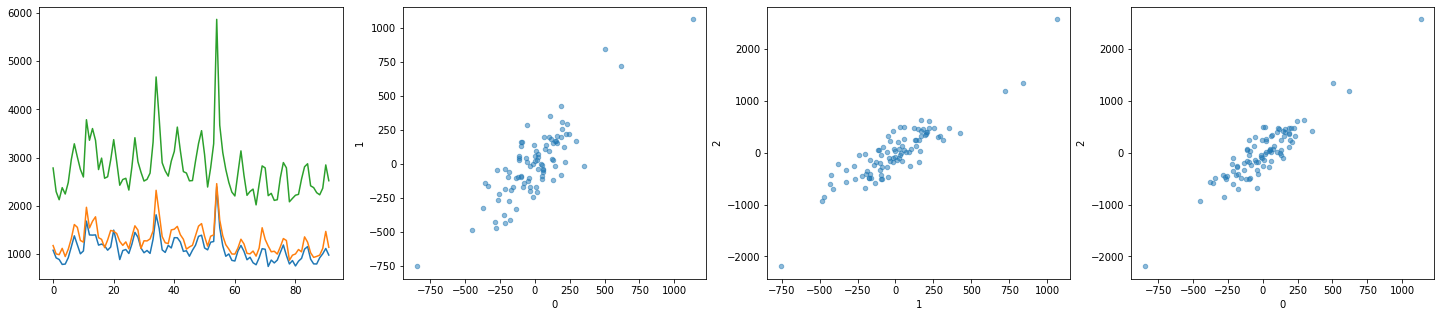

In [ ]:
# @markdown Plot
if divide_by == 2:
  print(df_agg.iloc[0, 1])
  print(df_agg.iloc[0, 2])

  df_designed = pd.DataFrame([
      df_design_tgt.loc[:, df_agg.iloc[0, 1]].sum(axis=1),
      df_design_tgt.loc[:, df_agg.iloc[0, 2]].sum(axis=1),
  ]).T
  df_designed_diff = pd.DataFrame(np.diff(df_designed, axis=0))

  print(df_designed_diff.corr())
  fig, axes = plt.subplots(nrows=1, ncols=divide_by, figsize=(25, 5))
  df_designed.plot(ax=axes[0], legend=False)
  df_designed_diff.plot.scatter(x=0, y=1, alpha=0.5, ax=axes[1])
else:
  print(df_agg.iloc[0, 1])
  print(df_agg.iloc[0, 2])
  print(df_agg.iloc[0, 3])

  df_designed = pd.DataFrame([
      df_design_tgt.loc[:, df_agg.iloc[0, 1]].sum(axis=1),
      df_design_tgt.loc[:, df_agg.iloc[0, 2]].sum(axis=1),
      df_design_tgt.loc[:, df_agg.iloc[0, 3]].sum(axis=1),
  ]).T
  df_designed_diff = pd.DataFrame(np.diff(df_designed, axis=0))

  print(df_designed_diff.corr())
  fig, axes = plt.subplots(nrows=1, ncols=divide_by + 1, figsize=(25, 5))
  df_designed.plot(ax=axes[0], legend=False)
  df_designed_diff.plot.scatter(x=0, y=1, alpha=0.5, ax=axes[1])
  df_designed_diff.plot.scatter(x=1, y=2, alpha=0.5, ax=axes[2])
  df_designed_diff.plot.scatter(x=0, y=2, alpha=0.5, ax=axes[3])

In [ ]:
if divide_by == 2:
  df_agg = pd.DataFrame([
      date_list.strftime("%Y/%m/%d"),
      df_design_all.loc[:, df_agg.iloc[0, 1]].sum(axis=1),
      df_design_all.loc[:, df_agg.iloc[0, 2]].sum(axis=1),
  ], index=['date','test','control']).T
else:
  df = pd.DataFrame([
      date_list.strftime("%Y/%m/%d"),
      df_design_all.loc[:, df_agg.iloc[0, 1]].sum(axis=1),
      df_design_all.loc[:, df_agg.iloc[0, 2]].sum(axis=1),
      df_design_all.loc[:, df_agg.iloc[0, 3]].sum(axis=1),
  ], index=['date','test_1', 'test_2','control']).T

In [ ]:
worksheet_objs = workbook.worksheets()
worksheets_list = []
for worksheet in worksheet_objs:
    worksheets_list.append(worksheet.title)

update_sheet = "for_CausalImpact" #@param {type: "string"}
if update_sheet not in worksheets_list:
    ci_sheet = workbook.add_worksheet(title=update_sheet, rows='100', cols='30')

ci_sheet.update([df.columns.values.tolist()] + df.values.tolist())

{'spreadsheetId': '1iAA1bYgv5xdTTK10aQ-lPNiNmWm-yFKdpGadogd41to',
 'updatedCells': 620,
 'updatedColumns': 4,
 'updatedRange': 'for_CausalImpact!A1:D155',
 'updatedRows': 155}